In [1]:
!pip install finance-datareader
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,713 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120828 files and dire

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime, timedelta
import random

num_images = 5000
day_num = 32

In [4]:
from keras.models import load_model

model1 = load_model('drive/MyDrive/Colab Notebooks/kosdaq500_kospi90_epoch50_1.h5')
model2 = load_model('drive/MyDrive/Colab Notebooks/kosdaq500_kospi90_epoch50_2.h5')

In [38]:
def convert_image(data, num_images, day_num, name, code, save = False, test = False):

    def alpha_blend(color1, color2, alpha):
        return [
            int((color1[0] * alpha + color2[0] * (1 - alpha))),
            int((color1[1] * alpha + color2[1] * (1 - alpha))),
            int((color1[2] * alpha + color2[2] * (1 - alpha))),
            255,
        ]


    # 해당 종목의 주가 데이터 - 100이 요구되는 이미지 수보다 적으면(상장직후는 변동이 심할 수있으니 제외)
    if num_images > len(data) - 60 - day_num:
        num_images = len(data) - 60 - day_num

    #return_datas는 이미지, 라벨링(상승이면1 하락이면0), 변동률, 날짜를 담고있음
    return_datas = []

    image_idx = 1
    while(image_idx <= num_images):

        if image_idx != 1:
            stock_data = data[-image_idx - day_num + 1 : -image_idx + 1]
        else:
            stock_data = data[-day_num:]
        # 이미지 크기 설정
        width, height = 96, 96

        # High, Low, Close, Volume 데이터 정규화
        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values
        close_prices = stock_data['Close'].values
        volume_data = stock_data['Volume'].values

        high_prices_norm = (high_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        low_prices_norm = (low_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        close_prices_norm = (close_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        volume_data_norm = height * (volume_data) / (2 * (np.max(volume_data)))

        if len(data) <= abs(-image_idx - day_num - 19):
            break

        # 이동평균선 추가를 위한 stock_data 생성
        if image_idx != 1:
            stock_data_ma20 = data[-image_idx - day_num - 19: -image_idx + 1]
        else:
            stock_data_ma20 = data[-image_idx - day_num - 19: ]

        stock_data_ma20 = stock_data_ma20.copy()
        stock_data_ma20['MA20'] = stock_data_ma20['Close'].rolling(window=20).mean()
        stock_data_ma20.dropna(inplace=True)

        # 이동평균선 값을 정규화
        stock_data_ma20['MA20_norm'] = (
                (stock_data_ma20['MA20'] - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
            )

        if len(data) <= abs(-image_idx - day_num - 39):
            break

        if image_idx != 1:
            stock_data_ma40 = data[-image_idx - day_num - 39: -image_idx + 1]
        else:
            stock_data_ma40 = data[-image_idx - day_num - 39: ]

        stock_data_ma40 = stock_data_ma40.copy()
        stock_data_ma40['MA40'] = stock_data_ma40['Close'].rolling(window=40).mean()
        stock_data_ma40.dropna(inplace=True)

        # 이동평균선 값을 정규화
        stock_data_ma40['MA40_norm'] = (
                (stock_data_ma40['MA40'] - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
            )

        if len(data) <= abs(-image_idx - day_num - 59):
            break

        if image_idx != 1:
            stock_data_ma60 = data[-image_idx - day_num - 59: -image_idx + 1]
        else:
            stock_data_ma60 = data[-image_idx - day_num - 59: ]

        stock_data_ma60 = stock_data_ma60.copy()
        stock_data_ma60['MA60'] = stock_data_ma60['Close'].rolling(window=60).mean()
        stock_data_ma60.dropna(inplace=True)

        # 이동평균선 값을 정규화
        stock_data_ma60['MA60_norm'] = (
                (stock_data_ma60['MA60'] - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
            )

        # 96x96 이미지 생성
        img = np.zeros((height, width, 4), dtype=np.uint8)  # 4 channels for RGBA

        fail_generate = False
        for day in range(32):
            high_price = int(high_prices_norm[day] * (height - 1))
            low_price = int(low_prices_norm[day] * (height - 1))
            close_price = int(close_prices_norm[day] * (height - 1))
            open_price = int(
                (
                    (stock_data['Open'].values[day] - np.min(low_prices))
                    / (np.max(high_prices) - np.min(low_prices))
                )
                * (height - 1)
            )
            volume = int(volume_data_norm[day])

            x_start = day * 3

            # 시가, 종가, 고가, 저가 막대그래프
            # 막대 왼쪽, 오른쪽 그리기 (시가, 종가 범위)
            for x in range(x_start, x_start + 3):
                if close_prices[day] > stock_data['Open'].values[day]:
                    color = [255, 0, 0, 255]  # 상승: 빨강
                    tail_color = [200, 0, 0, 255]  # 상승 시 꼬리: 어두운 빨강
                elif close_prices[day] < stock_data['Open'].values[day]:
                    color = [0, 0, 255, 255]  # 하락: 파랑
                    tail_color = [0, 0, 200, 255]  # 하락 시 꼬리: 어두운 파랑
                else: # 시가와 종가가 같을경우 어제보다 같거나 올랐으면 빨강, 아니면 파랑
                    if 0 <= stock_data['Change'].values[day]:
                        color = [255, 0, 0, 255]  # 상승: 빨강
                        tail_color = [200, 0, 0, 255]  # 상승 시 꼬리: 어두운 빨강
                    else:
                        color = [0, 0, 255, 255]  # 하락: 파랑
                        tail_color = [0, 0, 200, 255]  # 하락 시 꼬리: 어두운 파랑

                for y in range(min(open_price, close_price), max(open_price, close_price) + 1):
                    img[height - 1 - y, x] = color

            # 꼬리 그리기 (High, Low 범위)
            for x in range(x_start + 1, x_start + 2):
                for y in range(low_price, high_price + 1):
                    if img[height - 1 - y, x][0] != 255 and img[height - 1 - y, x][2] != 255:
                        img[height - 1 - y, x] = tail_color

            # 거래량 그리기
            for x in range(x_start, x_start + 3):
                overlapped = height - volume
                if overlapped >= 0 and overlapped < height:
                    img[overlapped:, x] = [
                        alpha_blend(img[y, x], [128, 128, 128, 255], 0.45)
                        for y in range(overlapped, height)
                    ]

            # 20일 이동평균선 그리기
            ma20_norm = stock_data_ma20.iloc[day]['MA20_norm']

            for x in range(x_start, x_start + 3):
                if not np.isnan(ma20_norm):
                    ma20_y = int(ma20_norm * (height - 1))
                    if 0 <= ma20_y < height:
                        for y in range(ma20_y - 1, ma20_y + 2):  # 이동평균선 주변에 블렌딩 처리
                            if 0 <= y < height:
                                new_color = alpha_blend([255, 255, 0, 255], img[height - 1 - y, x], 0.6)  # 노란색으로 변경
                                img[height - 1 - y, x] = new_color

            # 40일 이동평균선 그리기
            ma40_norm = stock_data_ma40.iloc[day]['MA40_norm']

            for x in range(x_start, x_start + 3):
                if not np.isnan(ma40_norm):
                    ma40_y = int(ma40_norm * (height - 1))
                    if 0 <= ma40_y < height:
                        for y in range(ma40_y - 1, ma40_y + 2):  # 이동평균선 주변에 블렌딩 처리
                            if 0 <= y < height:
                                new_color = alpha_blend([128, 0, 128, 255], img[height - 1 - y, x], 0.6)  # 보라색으로 변경
                                img[height - 1 - y, x] = new_color


            # 60일 이동평균선 그리기
            ma60_norm = stock_data_ma60.iloc[day]['MA60_norm']

            for x in range(x_start, x_start + 3):
                if not np.isnan(ma60_norm):
                    ma60_y = int(ma60_norm * (height - 1))
                    if 0 <= ma60_y < height:
                        for y in range(ma60_y - 1, ma60_y + 2):  # 이동평균선 주변에 블렌딩 처리
                            if 0 <= y < height:
                                new_color = alpha_blend([0, 255, 0, 255], img[height - 1 - y, x], 0.6)  # 초록색으로 변경
                                img[height - 1 - y, x] = new_color

        #이미지가 day_num(그려지기 원하는 거래일 수)미만으로 그려졌으면
        if fail_generate:
            image_idx += 1
            continue

        if save :
            # 이미지 저장
            img = Image.fromarray(img, 'RGBA')
            img.save(f'stock_data_image_{image_idx}.png')


        return_datas.append((img, name, code, stock_data.index[-1]))

        image_idx += 1


    return return_datas

In [27]:
def preprocess_data(data):
    # 0이나 NaN을 포함하는 행 제거
    data = data[data['Volume'] != 0]
    data = data.dropna(how='any')

    return data

In [7]:
df = pd.read_excel('drive/MyDrive/Colab Notebooks/kospi.xlsx', usecols=[0, 1], dtype={1: str})
df = df[~df.iloc[:, 1].str.contains("스팩")]
# df = df.sample(n=400, random_state=42)

# 첫 번째 열과 두 번째 열을 Nx2 리스트로 변환
stock_codes = df.values.tolist()

# 결과 출력
print(stock_codes)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[['095570', 'AJ네트웍스'], ['006840', 'AK홀딩스'], ['027410', 'BGF'], ['282330', 'BGF리테일'], ['138930', 'BNK금융지주'], ['001460', 'BYC'], ['001465', 'BYC우'], ['001040', 'CJ'], ['079160', 'CJ CGV'], ['00104K', 'CJ4우(전환)'], ['000120', 'CJ대한통운'], ['011150', 'CJ씨푸드'], ['011155', 'CJ씨푸드1우'], ['001045', 'CJ우'], ['097950', 'CJ제일제당'], ['097955', 'CJ제일제당 우'], ['000480', 'CR홀딩스'], ['000590', 'CS홀딩스'], ['012030', 'DB'], ['016610', 'DB금융투자'], ['005830', 'DB손해보험'], ['000990', 'DB하이텍'], ['139130', 'DGB금융지주'], ['001530', 'DI동일'], ['000210', 'DL'], ['001880', 'DL건설'], ['000215', 'DL우'], ['375500', 'DL이앤씨'], ['37550L', 'DL이앤씨2우(전환)'], ['37550K', 'DL이앤씨우'], ['007340', 'DN오토모티브'], ['004840', 'DRB동일'], ['155660', 'DSR'], ['069730', 'DSR제강'], ['017940', 'E1'], ['365550', 'ESR켄달스퀘어리츠'], ['383220', 'F&F'], ['007700', 'F&F홀딩스'], ['114090', 'GKL'], ['078930', 'GS'], ['006360', 'GS건설'], ['001250', 'GS글로벌'], ['007070', 'GS리테일'], ['078935', 'GS우'], ['012630', 'HDC'], ['039570', 'HDC랩스'], ['089470', 'HDC현대EP'], ['294870', 'H

In [40]:
# 엑셀 파일 읽기
df = pd.read_csv('drive/MyDrive/Colab Notebooks/kosdaq.csv', usecols=[0, 1], dtype={1: str})
# df = df[~df.iloc[:, 0].str.contains("스팩")]
df = df.iloc[:, [1, 0]]
# df = df.sample(n=400, random_state=42)

#첫 번째 열과 두 번째 열을 Nx2 리스트로 변환
stock_codes = df.values.tolist()

# 결과 출력
print(stock_codes)

[['457940', 'SK증권제10호스팩'], ['458320', 'KB제26호스팩'], ['448710', '코츠테크놀로지'], ['445680', '큐리옥스바이오시스템즈'], ['454750', '하나28호스팩'], ['440110', '파두'], ['373170', '엠아이큐브솔루션'], ['429270', '시지트로닉스'], ['172670', '에이엘티'], ['450940', '유안타제14호스팩'], ['388870', '파로스아이바이오'], ['438700', '버넥트'], ['406820', '뷰티스킨'], ['455910', 'SK증권제9호스팩'], ['432430', '와이랩'], ['321370', '센서뷰'], ['378340', '필에너지'], ['456440', 'DB금융스팩11호'], ['456490', '교보14호스팩'], ['274400', '이노시뮬레이션'], ['354320', '알멕'], ['440320', '오픈놀'], ['232830', '시큐센'], ['454640', '하나29호스팩'], ['455250', 'KB제25호스팩'], ['451700', '엔에이치스팩29호'], ['450050', '하이제8호스팩'], ['303360', '프로테옴텍'], ['348080', '큐라티스'], ['439090', '마녀공장'], ['405920', '나라셀라'], ['285800', '진영'], ['420770', '기가비스'], ['271830', '팸텍'], ['434480', '모니터랩'], ['340810', '씨유박스'], ['446840', '키움제8호스팩'], ['417790', '트루엔'], ['304360', '에스바이오메딕스'], ['298830', '슈어소프트테크'], ['393210', '토마토시스템'], ['424980', '마이크로투나노'], ['318160', '셀바이오휴먼텍'], ['448830', '미래에셋비전스팩3호'], ['448760', 'IBKS제22호스팩'], ['448370', '하

In [43]:
down_images = []
down_images_info = []

def process():
    global down_images, down_images_info

    for n in range(0, len(stock_codes), 50):
        result_images = []
        for i, ticker in enumerate(stock_codes[n:min(n+50, len(stock_codes))]):
            code, name = ticker[0], ticker[1]
            print(f"{n+i+1}번째 종목 {name} 추출중...   ")

            try:
                data = preprocess_data(fdr.DataReader(code, '2022-10-15'))  # 각 종목의 데이터 가져오기
                images = convert_image(data, 300, day_num, name, code)
                result_images += images
                print(f"{len(images)}개 추출완료. 누적{len(result_images)}개")
            except IndexError:
                print(f"{name}에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.")
                continue
        test_images = [image[0][:, :, :3] for image in result_images]
        test_images = np.array(test_images).reshape(-1, 96, 96, 3) / 255.0

        pred_probs1 = model1.predict(test_images)
        pred_probs2 = model2.predict(test_images)

        # 두 모델 같은 라벨이 하락으로 정답이라고 했을때

        selected_images = []
        selected_images_info = []

        for i in range(len(test_images)):
            pred_probs1_max_idx = np.argmax(pred_probs1[i])
            pred_probs2_max_idx = np.argmax(pred_probs2[i])

            if pred_probs1_max_idx == pred_probs2_max_idx and 0.5 < pred_probs1[i][0] and 0.81 <= pred_probs1[i][pred_probs1_max_idx] <= 0.91 and 0.87 <= pred_probs2[i][pred_probs2_max_idx] <= 0.88:
                selected_images.append(test_images[i])
                selected_images_info.append(result_images[i][1:])

        selected_images = np.array(selected_images)

        print(len(selected_images))
        for i in selected_images_info:
            print(i[0], str(i[-1])[:10])

        down_images.append(selected_images)
        down_images_info.append(selected_images_info)

In [ ]:
process()

1번째 종목 SK증권제10호스팩 추출중...   
0개 추출완료. 누적0개
2번째 종목 KB제26호스팩 추출중...   
0개 추출완료. 누적0개
3번째 종목 코츠테크놀로지 추출중...   
0개 추출완료. 누적0개
4번째 종목 큐리옥스바이오시스템즈 추출중...   
0개 추출완료. 누적0개
5번째 종목 하나28호스팩 추출중...   
0개 추출완료. 누적0개
6번째 종목 파두 추출중...   
0개 추출완료. 누적0개
7번째 종목 엠아이큐브솔루션 추출중...   
0개 추출완료. 누적0개
8번째 종목 시지트로닉스 추출중...   
0개 추출완료. 누적0개
9번째 종목 에이엘티 추출중...   
0개 추출완료. 누적0개
10번째 종목 유안타제14호스팩 추출중...   
0개 추출완료. 누적0개
11번째 종목 파로스아이바이오 추출중...   
0개 추출완료. 누적0개
12번째 종목 버넥트 추출중...   
0개 추출완료. 누적0개
13번째 종목 뷰티스킨 추출중...   
0개 추출완료. 누적0개
14번째 종목 SK증권제9호스팩 추출중...   
0개 추출완료. 누적0개
15번째 종목 와이랩 추출중...   
0개 추출완료. 누적0개
16번째 종목 센서뷰 추출중...   
0개 추출완료. 누적0개
17번째 종목 필에너지 추출중...   
0개 추출완료. 누적0개
18번째 종목 DB금융스팩11호 추출중...   
0개 추출완료. 누적0개
19번째 종목 교보14호스팩 추출중...   
0개 추출완료. 누적0개
20번째 종목 이노시뮬레이션 추출중...   
0개 추출완료. 누적0개
21번째 종목 알멕 추출중...   
0개 추출완료. 누적0개
22번째 종목 오픈놀 추출중...   
0개 추출완료. 누적0개
23번째 종목 시큐센 추출중...   
116개 추출완료. 누적116개
24번째 종목 하나29호스팩 추출중...   
0개 추출완료. 누적116개
25번째 종목 KB제25호스팩 추출중...   
0개 추출완료. 누적116개
26번째 종목 엔에이치스팩29호 추출중...

In [ ]:
for down in down_images_info:
    for i in down:
        print(i[0], str(i[2])[:10])

케이비아이동국실업 2023-02-16
코오롱우 2023-03-08
쿠쿠홈시스 2023-02-16
크래프톤 2023-05-24
풀무원 2023-05-30
한국주철관 2023-05-24
한화오션 2023-03-08
현대코퍼레이션홀딩스 2023-05-08

수산인더스트리 2023-04-18
이수화학 2023-03-17
코오롱플라스틱 2023-03-03
하나제약 2023-02-20
한일철강 2023-04-04
한화투자증권 2023-05-10
현대리바트 2023-07-07


In [ ]:
np.save('down_images_20230227-20230814.npy', down)

with open("down_images_info.txt", "w") as file:
    for info in down_images_info:
        # 튜플에 있는 문자열을 콤마로 구분 하나의 문자열로 합칩니다.
        line = ', '.join(info)
        file.write(f"{line}\n")

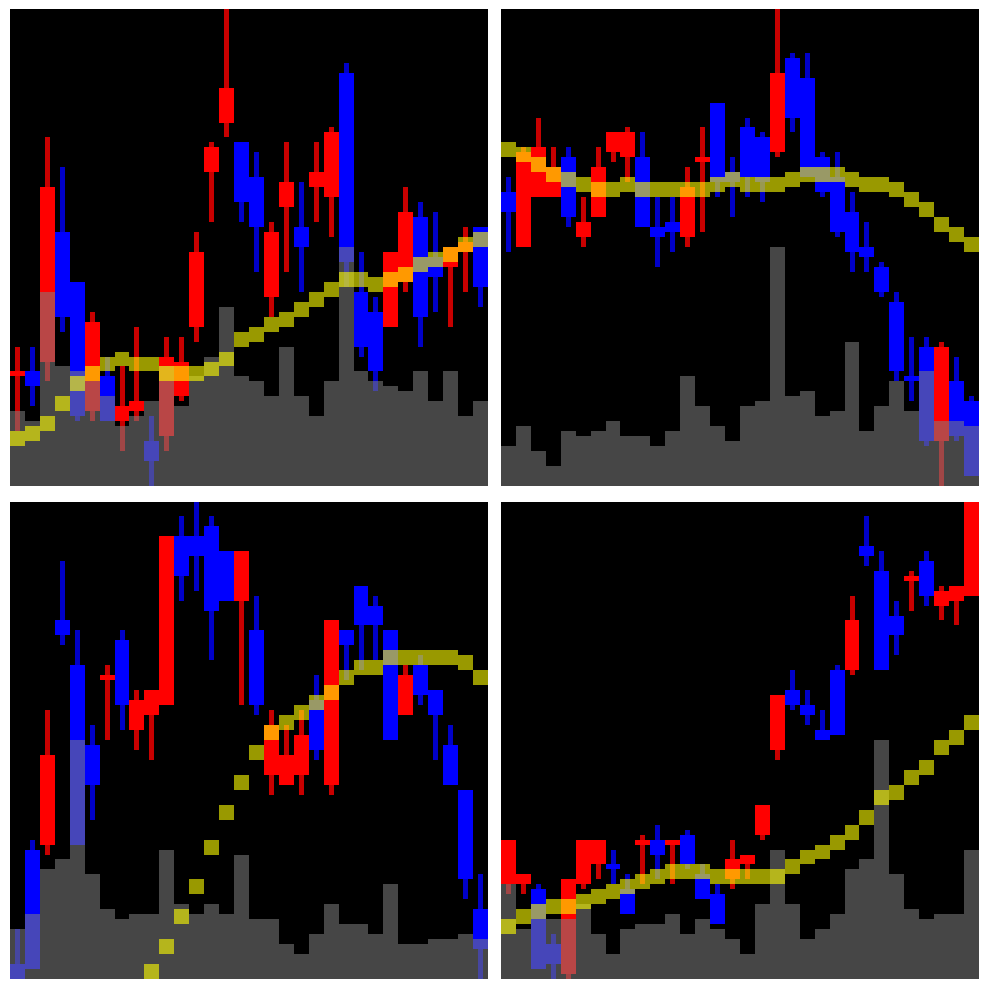

In [ ]:
import matplotlib.pyplot as plt

# 레이블이 0인 이미지 선택

# 이미지 출력 함수
def display_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(rows * cols):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 이미지 출력
num_examples = min(len(test_images), 7)
rows = cols = int(np.sqrt(num_examples))
display_images(test_images[:num_examples], rows, cols)


IndexError: ignored

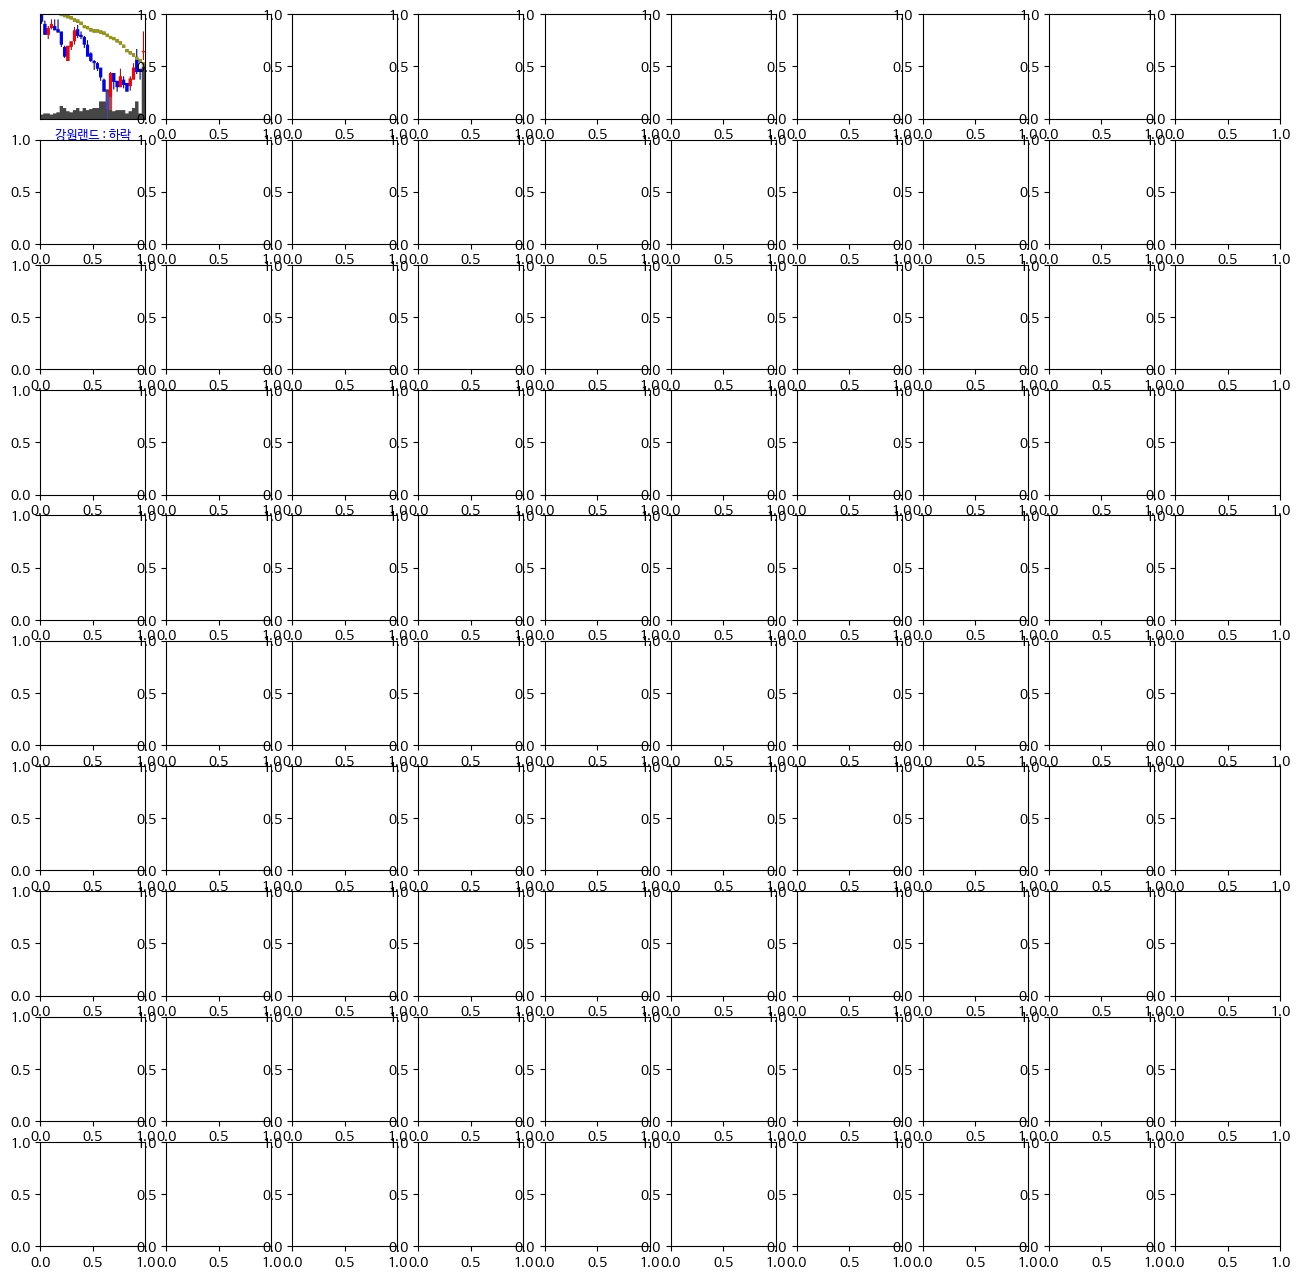

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
plt.rc('font', family='NanumBarunGothic')

# 현재 날짜를 'x월 x일' 형식으로 변환합니다.
today = datetime.now().strftime("%m월 %d일")

fig, axes = plt.subplots(10, 10, figsize=(16, 16))
for i in range(10):
    for j in range(10):
        img_idx = i * 10 + j
        img = Image.fromarray(test_images[img_idx])
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        # 색상 변경을 위해 text 함수를 사용합니다.
        color = 'red' if predicted_labels[i*10 + j] else 'blue'
        text = f'{stock_codes[i*10 + j][1]} : {"상승" if predicted_labels[i*10 + j] else "하락"}'
        axes[i, j].text(0.5, -0.15, text, fontsize=9, color=color, ha='center', va='center', transform=axes[i, j].transAxes)

# 제목 추가 (날짜 포함)
plt.suptitle(f'{today} 종가대비 향후 5거래일 평균 가격 예상', fontsize=20, y=0.95)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()


In [ ]:
a = fdr.DataReader('035250')
print(a.tail())

             Open   High    Low  Close   Volume    Change
Date                                                     
2023-08-04  15640  15910  15520  15840   526457  0.022595
2023-08-07  15840  16300  15840  16160   818666  0.020202
2023-08-08  16390  16740  15990  16070  1248098 -0.005569
2023-08-09  16140  16140  15830  16070   410114  0.000000
2023-08-10  16680  17270  16450  16680  3594068  0.037959
